## Ballistic Noise Model
* Characterized by straight lines of Pauli errors
* Introduce bit-flip error on edge $j$ and on $\xi - 1$ errors to right of edge $j$.

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import *
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
import stimcirq
from typing import *
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import time
from tqdm import tqdm
import scipy.stats as ss
import pickle
from pymatching import Matching
from ldpc import bposd_decoder
from CompassCode import Lattice2D, random_pauli, pcheck_clipX, pcheck_clipZ, print_pauli_error, stretched_ds_code_coloring

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [396]:
def pauli_mul_rules(p_1: str, p_2: str):
    if (p_1 == p_2):
        return '_' 
    elif (p_1 == 'X' and p_2 == 'Z' or p_1 == 'Z' and p_2 == 'X'):
        return 'Y' 
    elif (p_1 == 'X' and p_2 == 'Y' or p_1 == 'Y' and p_2 == 'X'):
        return 'Z' 
    elif (p_1 == 'Y' and p_2 == 'Z' or p_1 == 'Z' and p_2 == 'Y'):
        return 'X'
    elif ((p_1 == 'X' or p_1 == 'Y' or p_1 == 'Z') and p_2 == '_'):
        return p_1 
    elif ((p_2 == 'X' or p_2 == 'Y' or p_2 == 'Z') and p_1 == '_'):
        return p_2
    
def choose_error_locs(lat: Lattice2D, error_prob, dir=None, fixed_dir=True) -> List[Tuple]:
    dimX = lat.dimX 
    dimZ = lat.dimZ 
    err = []
    error_dir = ''
    if (fixed_dir):
        error_dir = np.random.choice(['U', 'D', 'L', 'R'])
    if (dir != None):
        error_dir = dir
    for _ in range(lat.size()):
        error_loc = (np.random.choice(list(range(dimX))), np.random.choice(list(range(dimZ))))
        error_type = np.random.choice(['X', 'Y', 'Z'])
        if (error_dir==''):
            error_dir = np.random.choice(['U', 'D', 'L', 'R'])
        if np.random.binomial(1, error_prob):
            err.append((error_loc, error_type, error_dir))
    return err


class BallisticNoiseModel():
    def __init__(self, p_err: float, p_dec: float, xi: int):
        self.p_start = p_err
        self.decay = p_dec
        self.xi = xi 

    def sample_error(self, lat: Lattice2D, dir=None, fixed_dir = True):
        dimX = lat.dimX 
        dimZ = lat.dimZ 
        curr_p = self.p_start
        error = np.zeros((dimX, dimZ), dtype=str)
        for i in range(dimX):
            for j in range(dimZ):
                error[i][j] = '_' 
        error_locs = choose_error_locs(lat, curr_p, dir, fixed_dir)
        if len(error_locs) == 0:
            error_str = '' 
            for r in error:
                for e in r:
                    error_str += e 
            return error, pauli2vector(error_str)
        
        for error_loc, error_type, dir in error_locs:
            error[error_loc[0]][error_loc[1]] = pauli_mul_rules(error[error_loc[0]][error_loc[1]], error_type)
            curr_p = 1
            for i in range(self.xi - 1):
                if (dir == 'U' and np.random.binomial(1, curr_p) and error_loc[0] - (i + 1) >= 0):
                    error[error_loc[0] - (i + 1)][error_loc[1]] = pauli_mul_rules(error[error_loc[0] - (i + 1)][error_loc[1]], error_type)
                    # print(error_loc[0] - (i + 1), error_loc[1])
                elif (dir == 'D' and np.random.binomial(1, curr_p) and error_loc[0] + (i + 1) < dimX):
                    error[error_loc[0] + (i + 1)][error_loc[1]] = pauli_mul_rules(error[error_loc[0] + (i + 1)][error_loc[1]], error_type)
                    # print(error_loc[0] + (i + 1), error_loc[1])
                elif (dir == 'L' and np.random.binomial(1, curr_p) and error_loc[1] - (i + 1) >= 0):
                    error[error_loc[0]][error_loc[1] - (i + 1)] = pauli_mul_rules(error[error_loc[0]][error_loc[1] - (i + 1)], error_type)
                    # print(error_loc[0], error_loc[1] - (i + 1))
                elif (dir == 'R' and np.random.binomial(1, curr_p) and error_loc[1] + (i + 1) < dimZ):
                    error[error_loc[0]][error_loc[1] + (i + 1)] = pauli_mul_rules(error[error_loc[0]][error_loc[1] + (i + 1)], error_type)
                    # print(error_loc[0], error_loc[1] + (i + 1))
                else:
                    break
                curr_p *= self.decay 

        error_str = '' 
        for r in error:
            for e in r:
                error_str += e 
        return error, pauli2vector(error_str)


    # class DiffusiveNoiseModel():
#     def __init__(self, p: float, xi: int):
#         self.p = p 
#         self.xi = xi 

#     def random_walk(start_pos: tuple, num_steps: int, dimX: int, dimZ: int):
        


#     def sample_error(self, p: float, lat: Lattice2D, decay: float):
#         dimX = lat.dimX
#         dimZ = lat.dimZ
#         self.p = p 
#         error = np.zeros((dimX, dimZ), dtype=str)
#         for i in range(dimX):
#             for j in range(dimZ):
#                 error[i][j] = 'I'
#         error_loc = (np.random.choice(list(range(dimX))), np.random.choice(list(range(dimZ))))
#         while ((dir == 'U' and error_loc[0] - self.xi < 0)
#             or (dir == 'D' and error_loc[0] + self.xi > dimZ - 1)
#             or (dir == 'L' and error_loc[1] - self.xi < 0)
#             or (dir == 'R' and error_loc[1] + self.xi > dimX - 1)):
#                 error_loc = (np.random.choice(list(range(dimX))), np.random.choice(list(range(dimZ))))
#         error_type = np.random.choice(['X', 'Y', 'Z'])
#         error[error_loc[0]][error_loc[1]] = error_type


In [403]:
lat = Lattice2D(6,6)
k = 2
bnm = BallisticNoiseModel(0.01, 0.95, 2)
pauli_error, error = bnm.sample_error(lat, dir='U', fixed_dir=True)
print(str(pauli_error))

[['_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_']
 ['_' '_' '_' '_' '_' '_']]


## Ballistic Noise Model - Fixed Direction + BP-Matching + Stretched Checks DS Code

In [297]:
lat = Lattice2D(8,8)
stretch_lat = stretched_ds_code_coloring(lat, 3, 'U')
print(stretch_lat)

000---001---002---003---004---005---006---007
 |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |
008---009---010---011---012---013---014---015
 |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |
016---017---018---019---020---021---022---023
 |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |
024---025---026---027---028---029---030---031
 |  ░  |  ░  |  ░  |  ░  |  ░  |  ░  |  ░  |
032---033---034---035---036---037---038---039
 |  ░  |  ░  |  ░  |  ░  |  ░  |  ░  |  ░  |
040---041---042---043---044---045---046---047
 |  ░  |  ░  |  ░  |  ░  |  ░  |  ░  |  ░  |
048---049---050---051---052---053---054---055
 |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |  ▓  |
056---057---058---059---060---061---062---063



In [407]:
dims = [5,6,7,8,9,10,11,12]
num_gauge_fixings = 40
phys_err_rates_range = np.linspace(0.001, 0.01, 7)
num_errors = 100
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for g_fix in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        lat = stretched_ds_code_coloring(lat, 3, dir='U')
        for i, phys_rate in enumerate(phys_err_rates_range):
            for num_error in range(num_errors):
                bnm = BallisticNoiseModel(phys_rate, 0.95, 2)
                pauli_error, error = bnm.sample_error(lat, dir='U', fixed_dir=True)
                pcheckX = lat.pcheckX()
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, error)
                syndromeX = twisted_product(pcheckZ, error)
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = phys_rate,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = phys_rate, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                weightsX = np.array(bpd_X.log_prob_ratios)/np.linalg.norm(bpd_X.log_prob_ratios)
                weightsZ = np.array(bpd_Z.log_prob_ratios)/np.linalg.norm(bpd_Z.log_prob_ratios)
                decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = error + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    # print(dim, fix_num, i)
                    logical_errors[dim][g_fix][i] += 1

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [13:24<00:00, 100.54s/it]


In [408]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_ballistic_fixed_1.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

[0.0005  0.00125 0.00225 0.0035  0.00525 0.00525 0.00825]
[0.      0.00075 0.0005  0.0015  0.002   0.004   0.00425]
[0.01125 0.02425 0.03975 0.0495  0.0605  0.075   0.0835 ]
[0.01375 0.03325 0.04725 0.064   0.07775 0.11025 0.116  ]
[0.0195  0.049   0.067   0.092   0.11875 0.139   0.14675]
[0.      0.      0.00025 0.0005  0.00075 0.00125 0.002  ]
[0.      0.      0.      0.00025 0.00025 0.0005  0.     ]
[0.      0.      0.0005  0.00025 0.      0.00075 0.0005 ]


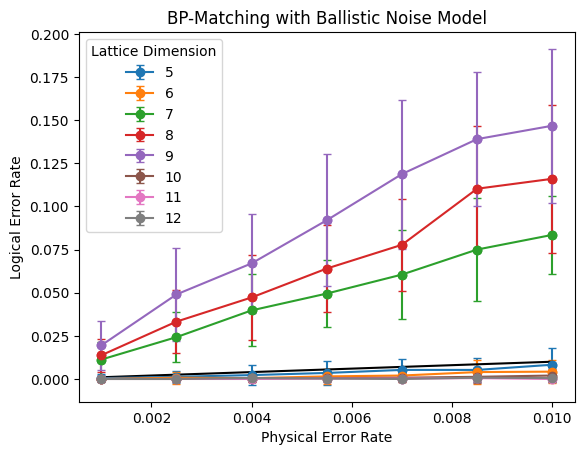

In [413]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    print(logical_error_list_mean)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.scatter(phys_err_rates_range, logical_error_list_mean)
    plt.errorbar(phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('BP-Matching with Ballistic Noise Model')
plt.plot(phys_err_rates_range, phys_err_rates_range, color='black')
plt.legend(title='Lattice Dimension')

### Compare with Surface Code + MWPM

In [414]:
dims = [5,6,7,8,9,10,11,12]
bootstrapped_runs = 40
phys_err_rates_range = np.linspace(0.001, 0.01, 7)
num_errors = 100
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                bnm = BallisticNoiseModel(phys_rate, 0.95, 2)
                pauli_error, error = bnm.sample_error(lat, dir='U', fixed_dir=True)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, error) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, error) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = error + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][bsr][i] += 1

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [01:00<03:01, 30.20s/it]


KeyboardInterrupt: 

In [303]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_surface_code_mwpm_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

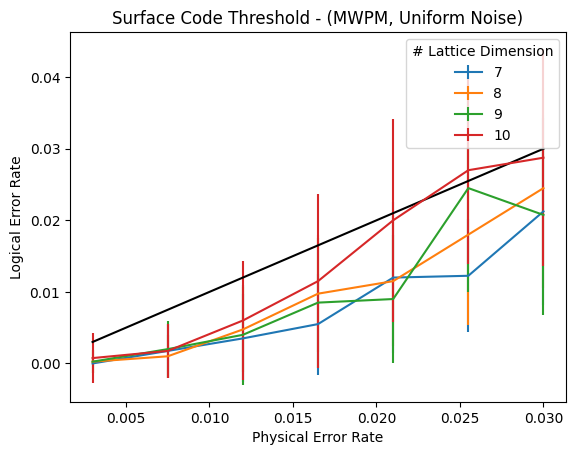

In [304]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (MWPM, Uniform Noise)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

### Surface Code with BP+Matching

In [305]:
dims = [7,8,9,10]
bootstrapped_runs = 40
phys_err_rates_range = np.linspace(0.001, 0.01, 7)
num_errors = 100
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for bsr in range(bootstrapped_runs):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate, phys_rate]
            for err in range(num_errors):
                bnm = BallisticNoiseModel(phys_rate, 0.95, 2)
                pauli_error, error = bnm.sample_error(lat, dir='U', fixed_dir=True)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ() 
                pcheck = np.vstack((pcheckX, pcheckZ)) 
                syndromeZ = twisted_product(pcheckX, error)
                syndromeX = twisted_product(pcheckZ, error)
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = phys_rate,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = phys_rate, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                weightsX = np.array(bpd_X.log_prob_ratios)/np.linalg.norm(bpd_X.log_prob_ratios)
                weightsZ = np.array(bpd_Z.log_prob_ratios)/np.linalg.norm(bpd_Z.log_prob_ratios)
                decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = error + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    # print(dim, fix_num, i)
                    logical_errors[dim][g_fix][i] += 1

100%|██████████| 4/4 [05:48<00:00, 87.14s/it]


In [306]:
surface_code_logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        surface_code_logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_surface_code_bp_matching_1', 'wb') as fp:
    pickle.dump(surface_code_logical_error_probs, fp)

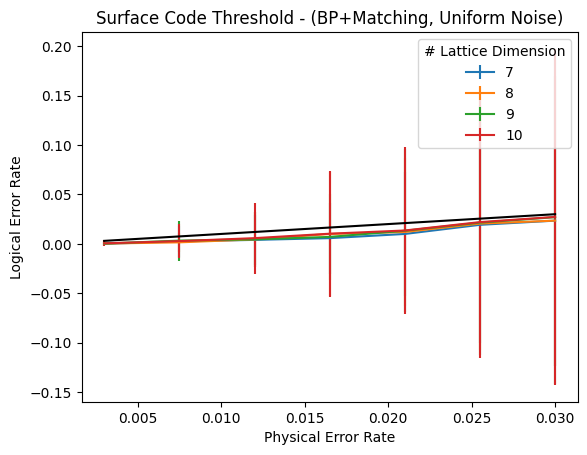

In [308]:
for dim in surface_code_logical_error_probs.keys():
    surface_code_logical_error_list = np.array(surface_code_logical_error_probs[dim])
    logical_error_list_mean = np.mean(surface_code_logical_error_list, axis=0)
    logical_error_list_std = np.std(surface_code_logical_error_list, axis=0)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Surface Code Threshold - (BP+Matching, Uniform Noise)')
plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Lattice Dimension')

## Ballistic Noise Model - Fixed Direction + BP+OSD
* $\xi = 3$ - Length of error chain
* $\gamma = 0.95$ - Error rate decay

In [416]:
dims = [5, 7, 9, 11, 13, 15]
num_faces_colored = [dim**2 for dim in dims]
num_gauge_fixings = 20
phys_err_rates_range = np.linspace(0.001, 0.33, 10)
num_errors = 100
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            for num_error in range(num_errors):
                bnm = BallisticNoiseModel(phys_rate, lat.dimZ//3)
                pauli_error, error = bnm.sample_error(3 * phys_rate, lat, 0.95)
                error_probability = 3*phys_rate
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, error) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, error) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 4
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 4
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                # weightsX = bpd_X.log_prob_ratios 
                # if (np.max(weightsX) > 20000000):
                #     weightsX = np.zeros((lat.size(),))
                # weightsZ = bpd_Z.log_prob_ratios
                # if (np.max(weightsZ) > 20000000):
                #     weightsZ = np.zeros((lat.size(),))
                # decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                # decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                # recoveryX = decodingX.decode(syndromeZ)
                # recoveryZ = decodingZ.decode(syndromeX)
                # recovery = np.concatenate((recoveryZ, recoveryX))
                recovery = np.concatenate((bpd_X.osdw_decoding, bpd_Z.osdw_decoding))
                corrected_error = error + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [08:49<00:00, 88.31s/it] 


In [417]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_ballistic_fixed.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

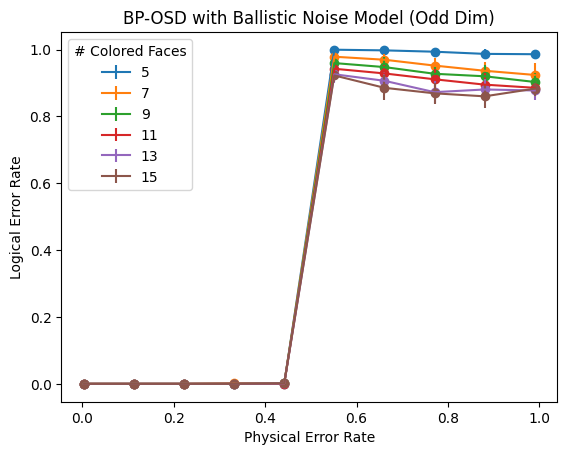

In [418]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.scatter(3 * phys_err_rates_range, logical_error_list_mean)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('BP-OSD with Ballistic Noise Model (Odd Dim)')
# plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')

In [419]:
dims = [5, 7, 9, 11, 13, 15]
num_faces_colored = [dim**2 for dim in dims]
num_gauge_fixings = 40
phys_err_rates_range = np.linspace(0.001, 0.33, 10)
num_errors = 200
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        for i, phys_rate in enumerate(phys_err_rates_range):
            for num_error in range(num_errors):
                bnm = BallisticNoiseModel(phys_rate, lat.dimZ//2)
                pauli_error, error = bnm.sample_error(3 * phys_rate, lat, 0.95)
                error_probability = 3*phys_rate
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, error) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, error) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = error + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [26:50<00:00, 268.45s/it]


In [420]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_ballistic_fixed_1.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

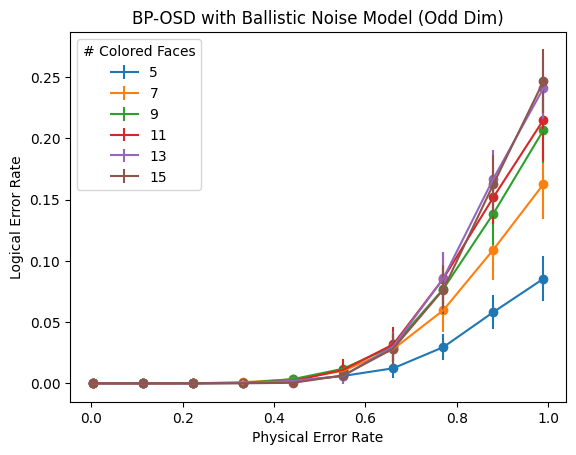

In [421]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.scatter(3 * phys_err_rates_range, logical_error_list_mean)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('BP-OSD with Ballistic Noise Model (Odd Dim)')
# plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')

### Comparison with Surface Code

In [8]:
dims = [5, 7, 9, 11, 13, 15]
num_faces_colored = [dim**2 for dim in dims]
num_gauge_fixings = 10
phys_err_rates_range = np.linspace(0.001, 0.33, 10)
num_errors = 100
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = Lattice2D(dim, dim)
        coloring = np.zeros(((dim - 1)**2,))
        locs = np.random.choice(list(range((dim - 1)**2)), (dim - 1)**2, replace=False)
        for loc in locs:
            coloring[loc] = np.random.choice([-1,1])
        lat.color_lattice(coloring)
        lat = compass_to_surface(lat.dimX, lat.dimZ)
        for i, phys_rate in enumerate(phys_err_rates_range):
            for num_error in range(num_errors):
                bnm = BallisticNoiseModel(phys_rate, lat.dimZ//2)
                pauli_error, error = bnm.sample_error(3 * phys_rate, lat, 0.95)
                error_probability = 3*phys_rate
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, error) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, error) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                decodingX = Matching.from_check_matrix(Hx)
                decodingZ = Matching.from_check_matrix(Hz)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = error + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [03:51<00:00, 38.52s/it]


In [9]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_ballistic_fixed_1.pkl', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

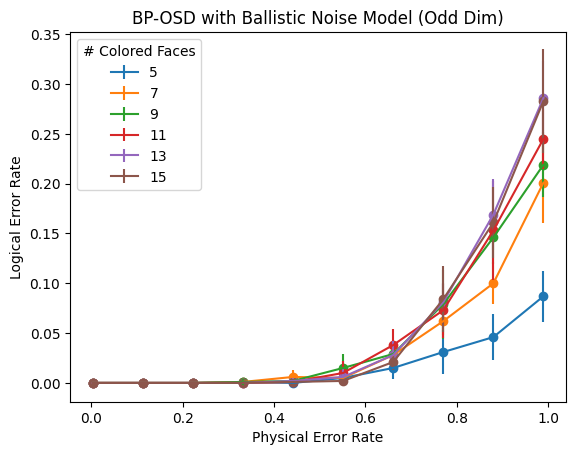

In [10]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.scatter(3 * phys_err_rates_range, logical_error_list_mean)
    plt.errorbar(3 * phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim))

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('BP-OSD with Ballistic Noise Model (Odd Dim)')
# plt.plot(3 * phys_err_rates_range, 3 * phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')